In [23]:
import pandas as pd
import os
import numpy as np
import cv2
import time
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import AveragePooling2D
from keras.layers import MaxPooling2D
from keras.applications import VGG16
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#from imutils import paths
import matplotlib.pyplot as plt
import argparse
from argparse import ArgumentParser


In [2]:
start = time.time()
Annotations = []
directory = 'Annotations512'
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    df = pd.read_csv(f,header = None,sep = ' ')
    locations = []
    for i in range(len(df)):
        n1 = int(df.iloc[i,0])
        n2 = int(df.iloc[i,1])
        n11 = max(n1-10,0)
        n12 = min(n1+10,511)
        n21 = max(n2-10,0)
        n22 = min(n2+10,511)
        label = int(df.iloc[i,3])
        locations.append([[n11, n12, n21, n22],[label]])
    
    Annotations.append(locations)
    Annotations.append(locations)
    
end = time.time()
print("process took",end-start,"seconds")
    

process took 20.275848627090454 seconds


In [3]:
# Image extraction on the basis of specific square mentioned above
start = time.time()
directory = 'Vehicules512'
INPUT_SIZE = (64, 64)
index = 0
data = []
labels = []
car_pickup_annotations = [] #startX, startY, endX, endY
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    orig = cv2.imread(f)
    localAnnotations = []
    for annotation in Annotations[index]:
        label = annotation[1][0]
        if(label == 1 or label == 11):
            roiOrig = orig[annotation[0][2]:annotation[0][3], annotation[0][0]:annotation[0][1]]
            roi = cv2.cvtColor(roiOrig, cv2.COLOR_BGR2RGB)
            roi = cv2.resize(roi, INPUT_SIZE)
            localAnnotations.append(annotation[0])
            data.append(roi)
            if(index%2 == 0):
                labels.append([label,1]) #color image
            else:
                labels.append([label,0]) #grey image
    index += 1
    # car_pickup_annotations contains all the cropped images
    car_pickup_annotations.append(localAnnotations)
        
end = time.time()
print("process took",end-start,"seconds")
# empty cell in the car_pickup_annotations denotes that, the particular image does not have any vehicle(car or pickup)


process took 139.5294771194458 seconds


In [ ]:
labels

In [7]:

car = 0
truck = 0
van = 0
pickup = 0
for lable in labels:
  
    if(lable[0] == 1): 
        car+=1
    if(lable[0] == 11): 
        pickup += 1

    
print("car = ",car)
print("pickup = ",pickup)


car =  2754
pickup =  1910


In [27]:

ap = ArgumentParser()
# # ap.add_argument("-d", "--dataset", required=True,
# # 	help="path to input dataset")
# ap.add_argument("-e", "--epochs", type=int, default=10,
# 	help="# of epochs to train our network for")
# ap.add_argument("-p", "--plot", type=str, default="plot.png",
# 	help="path to output loss/accuracy plot")
# args = vars(ap.parse_args())
args = ap.parse_args()

usage: ipykernel_launcher.py [-h]
ipykernel_launcher.py: error: unrecognized arguments: --ip=127.0.0.1 --stdin=9019 --control=9017 --hb=9016 --Session.signature_scheme="hmac-sha256" --Session.key=b"a064b676-cd9a-4f72-bd21-d44df679112e" --shell=9018 --transport="tcp" --iopub=9020 --f=c:\Users\Noopur\AppData\Roaming\jupyter\runtime\kernel-v2-2920MksTC1Uz7OdR.json


SystemExit: 2

c:\Users\Noopur\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [13]:

data = np.array(data)
labels = np.array(labels)
IsColor = labels[:,1]
labels = labels[:,0]

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
labels = np.c_[labels,IsColor]
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.25,  random_state=42) #stratify=labels,

trainIsColor = trainY[:,2]
trainY = trainY[:,:2]

testIsColor = testY[:,2]
testY = testY[:,:2]


In [12]:

start = time.time()
trainAug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

valAug = ImageDataGenerator()

mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

end = time.time()
print("process took",end-start,"seconds")


process took 0.0009996891021728516 seconds


In [16]:
start = time.time()
OrigVGGModel = VGG16()
print("################### Origional VGG16 model summary #######################")
print()
print(OrigVGGModel.summary())
print()

baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(64, 64, 3)))

print("######################## Base Model summary ###################################")
print()
print(baseModel.summary())
print()

# base model modified as inagenet is being trained on the ground images which did not work well in our case (arial images)
headModel = baseModel.layers[-3].output
headModel = AveragePooling2D(pool_size=(2, 2))(headModel)
#headModel = MaxPooling2D(pool_size=(2, 2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
#headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

#print(headModel.summary())
model = Model(inputs=baseModel.input, outputs=headModel)

print("######################## Main Model summary ###################################")
print()
print(model.summary())

for layer in baseModel.layers:
	layer.trainable = False
    
opt = Adam(lr=1e-5)

model.compile(loss= "binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

end = time.time()
print("process took",end-start,"seconds")


################### Origional VGG16 model summary #######################

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                    

In [29]:
start = time.time()

H = model.fit(
	x=trainAug.flow(trainX, trainY, batch_size=32),
	steps_per_epoch=len(trainX) // 32,
	validation_data=valAug.flow(testX, testY),
	validation_steps=len(testX) // 32,
	epochs=10) #args["epochs"])



end = time.time()
print("process took",end-start,"seconds")


Epoch 1/10
109/109 [==============================] - 194s 2s/step - loss: 26.6948 - accuracy: 0.4527 - val_loss: 9.4298 - val_accuracy: 0.4679
Epoch 2/10
109/109 [==============================] - 202s 2s/step - loss: 17.5685 - accuracy: 0.5118 - val_loss: 7.3011 - val_accuracy: 0.5608
Epoch 3/10
109/109 [==============================] - 202s 2s/step - loss: 13.6662 - accuracy: 0.5312 - val_loss: 5.9088 - val_accuracy: 0.5851
Epoch 4/10
109/109 [==============================] - 201s 2s/step - loss: 10.7344 - accuracy: 0.5589 - val_loss: 4.9236 - val_accuracy: 0.6068
Epoch 5/10
109/109 [==============================] - 220s 2s/step - loss: 8.9316 - accuracy: 0.5577 - val_loss: 4.1606 - val_accuracy: 0.6276
Epoch 6/10
109/109 [==============================] - 177s 2s/step - loss: 7.1599 - accuracy: 0.5770 - val_loss: 3.4826 - val_accuracy: 0.6267
Epoch 7/10
109/109 [==============================] - 158s 1s/step - loss: 5.8405 - accuracy: 0.5906 - val_loss: 3.0114 - val_accuracy: 0.

In [30]:

print("saving the model: ")
start = time.time()
#model and weights will be saved in current directory. you can save it to specific location also.
model.save('vggModified.h5')
model.save_weights('vggwgts')

end = time.time()
print("process took",end-start,"seconds")


saving the model: 
process took 4.258566856384277 seconds


In [31]:
start = time.time()
predictions = model.predict(x=testX.astype("float32"), batch_size=32)

end = time.time()
print("process took",end-start,"seconds")


37/37 [==============================] - 54s 1s/step
process took 54.585017681121826 seconds


In [32]:
print("classification report")
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1),target_names=['car','pickup']))

print()
from sklearn.metrics import confusion_matrix, accuracy_score
predict = predictions.argmax(axis = 1)
predict_color = predict[testIsColor == 1]
predict_grey = predict[testIsColor == 0]

y_true = testY.argmax(axis = 1)
y_true_color = y_true[testIsColor == 1]
y_true_grey = y_true[testIsColor == 0]

print("############## Combined ###############")
print("counfusion matrix")
print(confusion_matrix(y_true, predict))

print()
print("accuracy: ",accuracy_score(y_true, predict))
print()


print("############## Color ###############")
print("counfusion matrix")
print(confusion_matrix(y_true_color, predict_color))

print()
print("accuracy: ",accuracy_score(y_true_color, predict_color))
print()


print("############## grey ###############")
print("counfusion matrix")
print(confusion_matrix(y_true_grey, predict_grey))

print()
print("accuracy: ",accuracy_score(y_true_grey, predict_grey))


classification report
              precision    recall  f1-score   support

         car       0.68      0.78      0.73       691
      pickup       0.59      0.46      0.52       475

    accuracy                           0.65      1166
   macro avg       0.63      0.62      0.62      1166
weighted avg       0.64      0.65      0.64      1166


############## Combined ###############
counfusion matrix
[[540 151]
 [257 218]]

accuracy:  0.6500857632933105

############## Color ###############
counfusion matrix
[[237  76]
 [144 109]]

accuracy:  0.6113074204946997

############## grey ###############
counfusion matrix
[[303  75]
 [113 109]]

accuracy:  0.6866666666666666


In [33]:
directory = 'Vehicules512'
filename = '00000044_co.png'
f = os.path.join(directory, filename)
img = cv2.imread(f)
clone = img.copy()
INPUT_SIZE = (64, 64)
DataImg = []
for annotation in car_pickup_annotations[76]:
    roiOrig = img[annotation[2]:annotation[3], annotation[0]:annotation[1]]
    roi = cv2.cvtColor(roiOrig, cv2.COLOR_BGR2RGB)
    roi = cv2.resize(roi, (64,64))
    DataImg.append(roi)
    
DataImg = np.array(DataImg)
pred = model.predict(x = DataImg.astype("float32"),batch_size=32)
pred = pred.argmax(axis = 1)



1/1 [==============================] - 1s 780ms/step


(64, 64, 3)


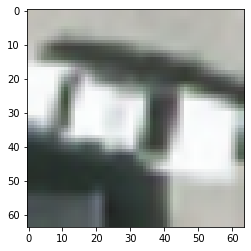

(64, 64, 3)


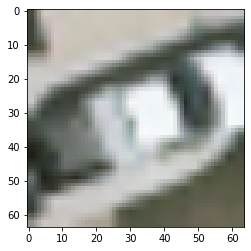

(64, 64, 3)


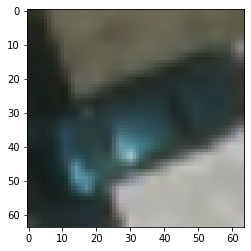

(64, 64, 3)


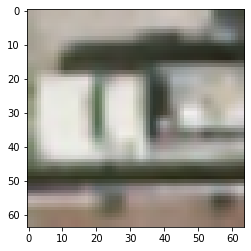

(64, 64, 3)


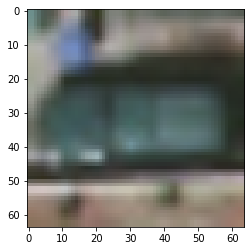

(64, 64, 3)


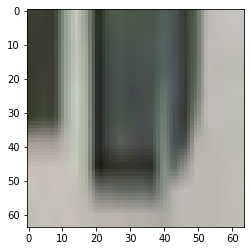

(64, 64, 3)


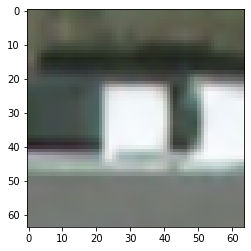

(64, 64, 3)


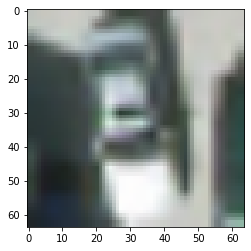

(64, 64, 3)


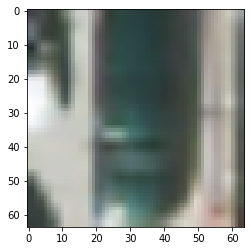

(64, 64, 3)


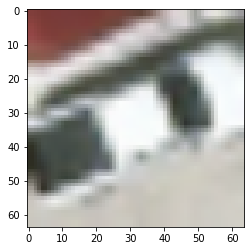

(64, 64, 3)


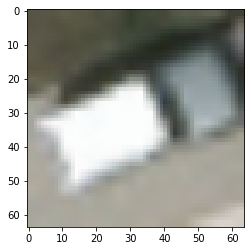

(64, 64, 3)


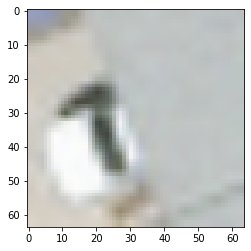

(64, 64, 3)


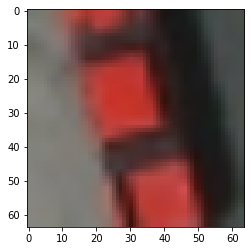

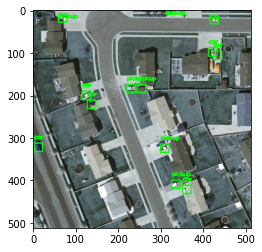

In [34]:
i = 0
for annotation in car_pickup_annotations[76]:
    predLabel = 'car'
    roiOrig = img[annotation[2]:annotation[3], annotation[0]:annotation[1]]
    roi = cv2.cvtColor(roiOrig, cv2.COLOR_BGR2RGB)
    roi = np.array(cv2.resize(roi, (64,64)))
    print(roi.shape)
    plt.imshow(roi)
    plt.show()
    
    predI = pred[i]
    if(predI == 0):
        predLabel = 'car'
    else:
        predLabel = 'pickup'
        
    startX = annotation[0]
    startY = annotation[2]
    endX   = annotation[1]
    endY   = annotation[3]
    i = i +1
    
    cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
    if(startY -10>10):
        y = startY - 10
    else:
        y = startY + 10
    cv2.putText(clone, predLabel, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
    plt.imshow(clone)



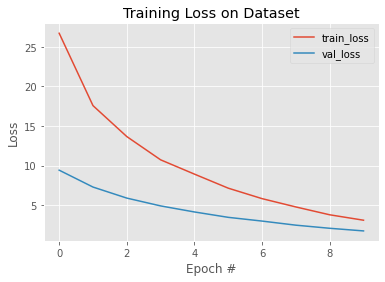

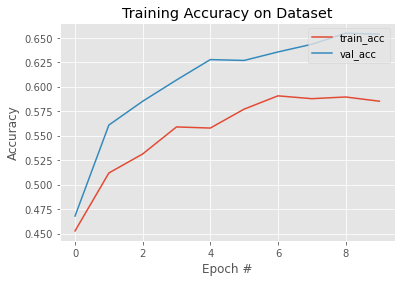

In [35]:
N = 10#args["epochs"]
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
#plt.savefig(args["plot"])

N = 10#args["epochs"]
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="upper right")
#plt.savefig(args["plot"])